# Part One: Cleaning Data and Preprocessing

In [1]:
import numpy as np 
import pandas as pd 
from xgboost import XGBRegressor
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

In [99]:
df = pd.read_csv('Agricultural_data/consolidado_final.csv')

In [100]:
# Select the desired columns
df = df[['date', 'price_soybean', 'real_interest_rate', 'SP500', 'SOYBEANS - USA PRODUCTION [mTons]']]

In [101]:
df = df.rename(columns={'SOYBEANS - USA PRODUCTION [mTons]': 'usa_prod'})

In [102]:
df.head()

,date,price_soybean,real_interest_rate,SP500,usa_prod
0,7/1/1988,787.50,4.43535,326.2,42.153
1,8/1/1988,867.50,4.54274,326.2,42.153
2,9/1/1988,813.00,4.70786,326.2,42.153
3,10/3/1988,789.25,4.46199,326.2,42.153
4,11/1/1988,763.75,4.35872,326.2,42.153


In [103]:
df['date'] = pd.to_datetime(df['date'])

In [104]:
# Remove the year 2023
df = df[df['date'].dt.year != 2023]

In [105]:
# Function to add labels in future soybean prices
# Reference: https://github.com/guptapiyush340/Soybean-Price-Prediction-Winning-solution-MinneAnalytics-Data-Science-Challenge/blob/master/XGBoost%20-%20Final%20Model.ipynb

def new_lags(data, lag_soybean_price, steps):
    ##Para 1 mes
    lag_col= ['price_soybean', 'real_interest_rate', 'SP500', 'usa_prod']
    t = 1
    data=data.assign(**{'{} (t-{})'.format(col, t): data[col].shift(+t) for col in lag_col})
    ##Para 3 y 6 meses
    lags = range(3, lag_soybean_price, steps)
    data=data.assign(**{
        '{} (t-{})'.format(col, t): data[col].shift(+t)
        for t in lags
        for col in lag_col
    })
    
    
    return data

In [106]:
df = new_lags(df, lag_soybean_price = 7, steps = 3)
df.head(10)

,date,price_soybean,real_interest_rate,SP500,usa_prod,price_soybean (t-1),real_interest_rate (t-1),SP500 (t-1),usa_prod (t-1),price_soybean (t-3),real_interest_rate (t-3),SP500 (t-3),usa_prod (t-3),price_soybean (t-6),real_interest_rate (t-6),SP500 (t-6),usa_prod (t-6)
0,1988-07-01,787.50,4.43535,326.2,42.153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1988-08-01,867.50,4.54274,326.2,42.153,787.50,4.43535,326.2,42.153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1988-09-01,813.00,4.70786,326.2,42.153,867.50,4.54274,326.2,42.153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1988-10-03,789.25,4.46199,326.2,42.153,813.00,4.70786,326.2,42.153,787.50,4.43535,326.2,42.153,NaN,NaN,NaN,NaN
4,1988-11-01,763.75,4.35872,326.2,42.153,789.25,4.46199,326.2,42.153,867.50,4.54274,326.2,42.153,NaN,NaN,NaN,NaN
5,1988-12-01,819.25,4.61794,326.2,42.153,763.75,4.35872,326.2,42.153,813.00,4.70786,326.2,42.153,NaN,NaN,NaN,NaN
6,1989-01-02,772.75,4.86319,326.2,52.354,819.25,4.61794,326.2,42.153,789.25,4.46199,326.2,42.153,787.50,4.43535,326.2,42.153
7,1989-02-01,773.50,4.73188,326.2,52.354,772.75,4.86319,326.2,52.354,763.75,4.35872,326.2,42.153,867.50,4.54274,326.2,42.153
8,1989-03-01,738.25,4.97372,326.2,52.354,773.50,4.73188,326.2,52.354,819.25,4.61794,326.2,42.153,813.00,4.70786,326.2,42.153
9,1989-04-03,729.50,4.87105,326.2,52.354,738.25,4.97372,326.2,52.354,772.75,4.86319,326.2,52.354,789.25,4.46199,326.2,42.153


In [107]:
df.tail(10)

,date,price_soybean,real_interest_rate,SP500,usa_prod,price_soybean (t-1),real_interest_rate (t-1),SP500 (t-1),usa_prod (t-1),price_soybean (t-3),real_interest_rate (t-3),SP500 (t-3),usa_prod (t-3),price_soybean (t-6),real_interest_rate (t-6),SP500 (t-6),usa_prod (t-6)
404,2022-03-01,1618.25,0.34709,1529.8,116.377,1636.75,0.44159,1494.9,116.377,1339.25,0.09169,1539.1,121.528,1256.00,-0.19473,1429.5,121.528
405,2022-04-01,1684.75,0.94940,1454.4,116.377,1618.25,0.34709,1529.8,116.377,1490.50,0.31950,1515.7,116.377,1249.50,0.08790,1495.9,121.528
406,2022-05-02,1683.25,1.20390,1479.3,116.377,1684.75,0.94940,1454.4,116.377,1636.75,0.44159,1494.9,116.377,1217.25,0.16400,1539.1,121.528
407,2022-06-01,1458.00,1.02509,1357.8,116.377,1683.25,1.20390,1479.3,116.377,1618.25,0.34709,1529.8,116.377,1339.25,0.09169,1539.1,121.528
408,2022-07-01,1468.50,1.06217,1436.9,116.377,1458.00,1.02509,1357.8,116.377,1684.75,0.94940,1454.4,116.377,1490.50,0.31950,1515.7,116.377
409,2022-08-01,1422.50,0.85563,1391.6,116.377,1468.50,1.06217,1436.9,116.377,1683.25,1.20390,1479.3,116.377,1636.75,0.44159,1494.9,116.377
410,2022-09-01,1364.75,1.20425,1272.3,116.377,1422.50,0.85563,1391.6,116.377,1458.00,1.02509,1357.8,116.377,1618.25,0.34709,1529.8,116.377
411,2022-10-03,1419.50,1.79733,1416.5,116.377,1364.75,1.20425,1272.3,116.377,1468.50,1.06217,1436.9,116.377,1684.75,0.94940,1454.4,116.377
412,2022-11-01,1469.50,1.93071,1443.1,116.377,1419.50,1.79733,1416.5,116.377,1422.50,0.85563,1391.6,116.377,1683.25,1.20390,1479.3,116.377
413,2022-12-01,1524.00,1.57613,1443.1,116.377,1469.50,1.93071,1443.1,116.377,1364.75,1.20425,1272.3,116.377,1458.00,1.02509,1357.8,116.377


In [108]:
# Extract month and year
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [109]:
# Create cyclic features using sine and cosine transformations
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['year_sin'] = np.sin(2 * np.pi * df['year'] / df['year'].max())
df['year_cos'] = np.cos(2 * np.pi * df['year'] / df['year'].max())

In [110]:
df = df.drop(columns=['date'], axis=1)

In [111]:
# Fill null values with rolling median and backfill remaining nulls
rolling_median = df.rolling(window=36, min_periods=1).median()
df_filled = df.fillna(rolling_median)
df = df_filled.fillna(method='bfill')

In [112]:
nombres_columnas = df.columns.tolist()
selected_columns = []
for i in range(1, df.shape[1]):
    selected_columns.append(nombres_columnas[i])

In [77]:
selected_columns = [df.columns.tolist()[i] for i in range(1, df.shape[1])]

In [113]:
# Scale selected columns using MinMaxScaler
scaler = MinMaxScaler()
df[selected_columns] = scaler.fit_transform(df[selected_columns])

In [114]:
# Check for any remaining null values
num_null_rows = df.isnull().sum(axis=1).sum()
num_null_rows

0

In [115]:
df

,price_soybean,real_interest_rate,SP500,usa_prod,price_soybean (t-1),real_interest_rate (t-1),SP500 (t-1),usa_prod (t-1),price_soybean (t-3),real_interest_rate (t-3),...,price_soybean (t-6),real_interest_rate (t-6),SP500 (t-6),usa_prod (t-6),month,year,month_sin,month_cos,year_sin,year_cos
0,787.50,0.899947,0.000000,0.000000,0.272249,0.899947,0.000000,0.000000,0.272249,0.899947,...,0.272249,0.899947,0.000000,0.000000,0.545455,0.0,0.250000,0.066987,0.0,0.0
1,867.50,0.919905,0.000000,0.000000,0.272249,0.899947,0.000000,0.000000,0.272249,0.899947,...,0.272249,0.899947,0.000000,0.000000,0.636364,0.0,0.066987,0.250000,0.0,0.0
2,813.00,0.950591,0.000000,0.000000,0.332332,0.919905,0.000000,0.000000,0.272249,0.899947,...,0.272249,0.899947,0.000000,0.000000,0.727273,0.0,0.000000,0.500000,0.0,0.0
3,789.25,0.904898,0.000000,0.000000,0.291401,0.950591,0.000000,0.000000,0.272249,0.899947,...,0.272249,0.899947,0.000000,0.000000,0.818182,0.0,0.066987,0.750000,0.0,0.0
4,763.75,0.885706,0.000000,0.000000,0.273564,0.904898,0.000000,0.000000,0.332332,0.919905,...,0.272249,0.899947,0.000000,0.000000,0.909091,0.0,0.250000,0.933013,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,1422.50,0.234677,0.878391,0.935106,0.783703,0.273061,0.915739,0.935106,0.944987,0.299401,...,0.910064,0.157730,0.963558,0.935106,0.636364,1.0,0.066987,0.250000,1.0,1.0
410,1364.75,0.299466,0.780031,0.935106,0.749155,0.234677,0.878391,0.935106,0.775817,0.266170,...,0.896170,0.140167,0.992332,0.935106,0.727273,1.0,0.000000,0.500000,1.0,1.0
411,1419.50,0.409686,0.898920,0.935106,0.705783,0.299466,0.780031,0.935106,0.783703,0.273061,...,0.946113,0.252103,0.930167,0.935106,0.818182,1.0,0.066987,0.750000,1.0,1.0
412,1469.50,0.434474,0.920851,0.935106,0.746902,0.409686,0.898920,0.935106,0.749155,0.234677,...,0.944987,0.299401,0.950697,0.935106,0.909091,1.0,0.250000,0.933013,1.0,1.0


## XGBoost Model for 1 Month

In [116]:
y = df['price_soybean']
X = df[['price_soybean (t-1)', 'real_interest_rate (t-1)', 'SP500 (t-1)', 'usa_prod (t-1)', 
        'month', 'year', 'month_sin', 'month_cos', 'year_sin', 'year_cos']]

In [117]:
X

,price_soybean (t-1),real_interest_rate (t-1),SP500 (t-1),usa_prod (t-1),month,year,month_sin,month_cos,year_sin,year_cos
0,0.272249,0.899947,0.000000,0.000000,0.545455,0.0,0.250000,0.066987,0.0,0.0
1,0.272249,0.899947,0.000000,0.000000,0.636364,0.0,0.066987,0.250000,0.0,0.0
2,0.332332,0.919905,0.000000,0.000000,0.727273,0.0,0.000000,0.500000,0.0,0.0
3,0.291401,0.950591,0.000000,0.000000,0.818182,0.0,0.066987,0.750000,0.0,0.0
4,0.273564,0.904898,0.000000,0.000000,0.909091,0.0,0.250000,0.933013,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
409,0.783703,0.273061,0.915739,0.935106,0.636364,1.0,0.066987,0.250000,1.0,1.0
410,0.749155,0.234677,0.878391,0.935106,0.727273,1.0,0.000000,0.500000,1.0,1.0
411,0.705783,0.299466,0.780031,0.935106,0.818182,1.0,0.066987,0.750000,1.0,1.0
412,0.746902,0.409686,0.898920,0.935106,0.909091,1.0,0.250000,0.933013,1.0,1.0


In [123]:
y_log = np.log(y)

In [119]:
#X_train, X_eval, y_train_log, y_eval_log = train_test_split(X,y,test_size=0.3,random_state=42)
X_train, X_test, y_train_log, y_test_log = train_test_split(X,y_log,test_size=0.3,random_state=42)

In [120]:
# Instanciate model
model_xgb = XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.1)

In [121]:
#pipe_xgb = make_pipeline(model_xgb)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer

rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)
mape = make_scorer(lambda y_true, y_pred: mean_absolute_percentage_error(y_true, y_pred))

cross_val_score(model_xgb,X,y,cv=5,scoring=mape,n_jobs=-1).mean()

0.07909987106575707

In [122]:
cross_val_score(model_xgb,X,y_log,cv=5,scoring=mape,n_jobs=-1).mean()

0.011689224407717237

In [124]:
model_xgb.fit(X_train, y_train_log,
        verbose=False,
        eval_set=[(X_train, y_train_log)],
        eval_metric=["mape"],
        early_stopping_rounds=10)

/home/caromezach/.pyenv/versions/3.10.6/envs/Agricultural_Market_Predictions/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/caromezach/.pyenv/versions/3.10.6/envs/Agricultural_Market_Predictions/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [125]:
Results = {}
Results['y_predict_1'] = np.exp(model_xgb.predict(X_test))

In [126]:
Results['y_test_1'] = np.exp(y_test_log)

In [127]:
Results['year'] = X_test['year']

In [128]:
results = pd.DataFrame.from_dict(Results)
results

,y_predict_1,y_test_1,year
358,991.120544,1018.50,0.882353
350,911.034668,968.25,0.852941
373,858.597290,869.00,0.911765
399,1301.654541,1249.50,0.970588
369,890.330750,854.00,0.911765
...,...,...,...
268,1302.133789,1243.00,0.647059
148,472.399292,502.00,0.352941
16,564.331482,582.75,0.029412
66,700.111450,686.75,0.176471


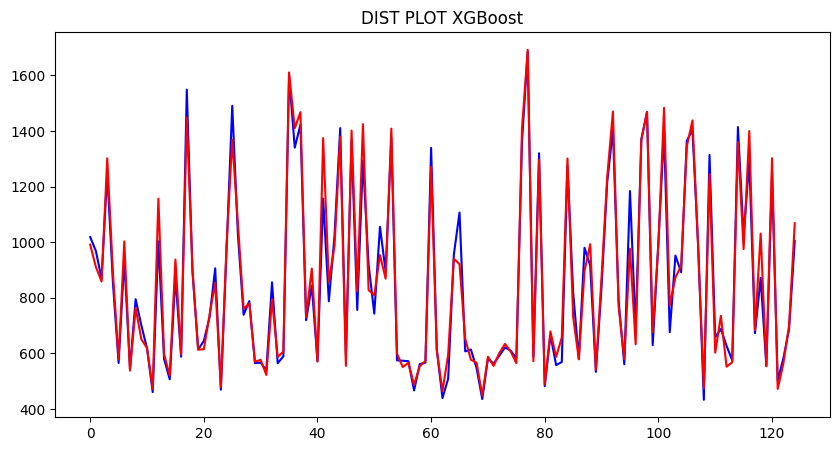

In [129]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(range(len(Results['y_test_1'])), Results['y_test_1'], 'b',label='Actual')
ax.plot(range(len(Results['y_predict_1'])), Results['y_predict_1'], 'r', label='Predicted')
plt.title('DIST PLOT XGBoost')
plt.xlabel('')
plt.ylabel('')
plt.show()

## XGBoost Model for 3 and 6 months

In [130]:
data_copy = df.copy()
data_copy

,price_soybean,real_interest_rate,SP500,usa_prod,price_soybean (t-1),real_interest_rate (t-1),SP500 (t-1),usa_prod (t-1),price_soybean (t-3),real_interest_rate (t-3),...,price_soybean (t-6),real_interest_rate (t-6),SP500 (t-6),usa_prod (t-6),month,year,month_sin,month_cos,year_sin,year_cos
0,787.50,0.899947,0.000000,0.000000,0.272249,0.899947,0.000000,0.000000,0.272249,0.899947,...,0.272249,0.899947,0.000000,0.000000,0.545455,0.0,0.250000,0.066987,0.0,0.0
1,867.50,0.919905,0.000000,0.000000,0.272249,0.899947,0.000000,0.000000,0.272249,0.899947,...,0.272249,0.899947,0.000000,0.000000,0.636364,0.0,0.066987,0.250000,0.0,0.0
2,813.00,0.950591,0.000000,0.000000,0.332332,0.919905,0.000000,0.000000,0.272249,0.899947,...,0.272249,0.899947,0.000000,0.000000,0.727273,0.0,0.000000,0.500000,0.0,0.0
3,789.25,0.904898,0.000000,0.000000,0.291401,0.950591,0.000000,0.000000,0.272249,0.899947,...,0.272249,0.899947,0.000000,0.000000,0.818182,0.0,0.066987,0.750000,0.0,0.0
4,763.75,0.885706,0.000000,0.000000,0.273564,0.904898,0.000000,0.000000,0.332332,0.919905,...,0.272249,0.899947,0.000000,0.000000,0.909091,0.0,0.250000,0.933013,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,1422.50,0.234677,0.878391,0.935106,0.783703,0.273061,0.915739,0.935106,0.944987,0.299401,...,0.910064,0.157730,0.963558,0.935106,0.636364,1.0,0.066987,0.250000,1.0,1.0
410,1364.75,0.299466,0.780031,0.935106,0.749155,0.234677,0.878391,0.935106,0.775817,0.266170,...,0.896170,0.140167,0.992332,0.935106,0.727273,1.0,0.000000,0.500000,1.0,1.0
411,1419.50,0.409686,0.898920,0.935106,0.705783,0.299466,0.780031,0.935106,0.783703,0.273061,...,0.946113,0.252103,0.930167,0.935106,0.818182,1.0,0.066987,0.750000,1.0,1.0
412,1469.50,0.434474,0.920851,0.935106,0.746902,0.409686,0.898920,0.935106,0.749155,0.234677,...,0.944987,0.299401,0.950697,0.935106,0.909091,1.0,0.250000,0.933013,1.0,1.0


In [133]:
Variables = {}
Scores = {}
Results = {}
#Selected_features = []
for iteration in range(3, 7, 3):
    data_copy = df.copy()
    #y_names.append('y_{}'.format('iteration'))
    Variables['y_{}'.format(iteration)] = np.log(data_copy['price_soybean'])
    Selected_features = [data_copy.columns.tolist()[i] for i in range(16, data_copy.shape[1])]
    Selected_features.append('{} (t-{})'.format('price_soybean', iteration))
    Selected_features.append('{} (t-{})'.format('real_interest_rate', iteration))
    Selected_features.append('{} (t-{})'.format('SP500', iteration))
    Selected_features.append('{} (t-{})'.format('usa_prod', iteration))
    Variables['X_{}'.format(iteration)] = data_copy[Selected_features]
    y_log = Variables['y_{}'.format(iteration)]
    X = Variables['X_{}'.format(iteration)]
    X_train, X_test, y_train_log, y_test_log = train_test_split(X,y_log,test_size=0.3,random_state=42)
    Scores['cross_val_score_{}'.format(iteration)] = cross_val_score(model_xgb,X,y_log,cv=5,scoring=mape,n_jobs=-1).mean()
    model_xgb.fit(X_train, y_train_log,
        verbose=False,
        eval_set=[(X_train, y_train_log)],
        eval_metric=["mape"],
        early_stopping_rounds=10)
    Results['y_predict_{}'.format(iteration)] = np.exp(model_xgb.predict(X_test))
    Results['y_test_{}'.format(iteration)] = np.exp(y_test_log)
    #print(y)
   

/home/caromezach/.pyenv/versions/3.10.6/envs/Agricultural_Market_Predictions/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/caromezach/.pyenv/versions/3.10.6/envs/Agricultural_Market_Predictions/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/caromezach/.pyenv/versions/3.10.6/envs/Agricultural_Market_Predictions/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/caromezach/.pyenv/versions/3.10.6/envs/Agricultural_Market_

In [134]:
Scores

{'cross_val_score_3': 0.018812301788159326,
 'cross_val_score_6': 0.02583090534234389}

In [135]:
results = pd.DataFrame.from_dict(Results)
results

,y_predict_3,y_test_3,y_predict_6,y_test_6
358,965.913757,1018.50,941.238464,1018.50
350,938.537415,968.25,948.816650,968.25
373,885.107788,869.00,888.077148,869.00
399,1366.040527,1249.50,1396.623413,1249.50
369,889.059326,854.00,924.471863,854.00
...,...,...,...,...
268,1185.489258,1243.00,1116.531616,1243.00
148,482.745300,502.00,482.529633,502.00
16,556.425964,582.75,678.324768,582.75
66,657.583740,686.75,674.228027,686.75


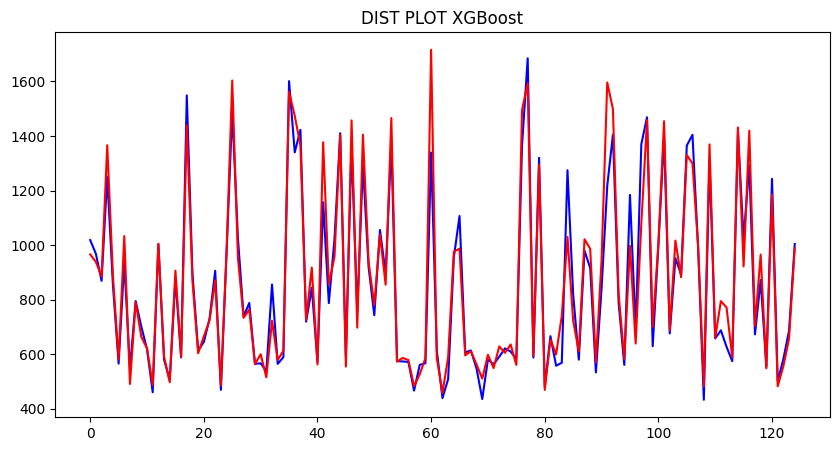

In [136]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(range(len(results['y_test_3'])), results['y_test_3'], 'b',label='Actual')
ax.plot(range(len(results['y_predict_3'])), results['y_predict_3'], 'r', label='Predicted')
plt.title('DIST PLOT XGBoost')
plt.xlabel('')
plt.ylabel('')
plt.show()

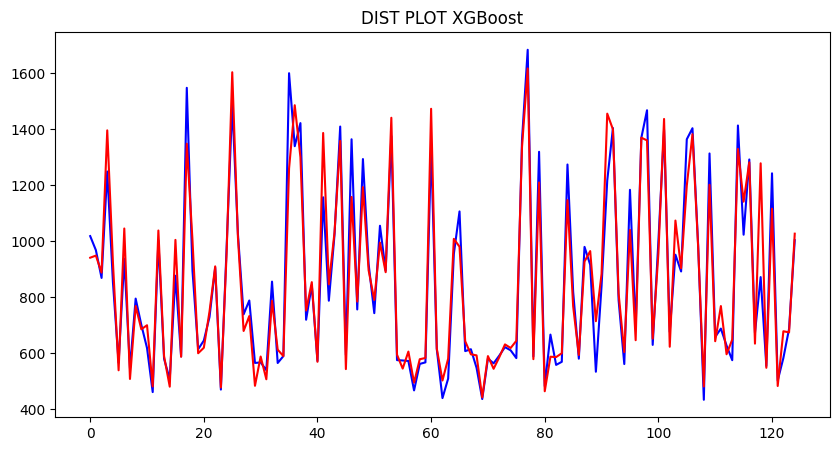

In [137]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(range(len(results['y_test_6'])), results['y_test_6'], 'b',label='Actual')
ax.plot(range(len(results['y_predict_6'])), results['y_predict_6'], 'r', label='Predicted')
plt.title('DIST PLOT XGBoost')
plt.xlabel('')
plt.ylabel('')
plt.show()